# SEME - Search Engine Manipulation Effect

If you've been feeling a bit nervous lately about Google-and-the-Gang -> **Well, it's about time!**

Google, and other tech companies in the U.S and China pose as serious threats to democracy.

In this day and age, information flows at an unmeasurable speed. Due to the rapid evolution of the internet, our society and social standards have changed drastically. It is fair to say that our lives are highly influenced by Big Tech Internet companies such as Amazon, Google, Facebook and other social media platforms, if not controlled. We rely on "the internet giants". 

We have grown customed to the use of search engines: e.g. 'Google' on a daily basis.
But are **we** aware of how they impact our mindset and beliefs?

In this Notebook we will illustrate and manipulate data from a research done by Dr. Robert Epstein and Ronald E. Robersson in the years 2015-2017. This research: **"The search engine manipulation effect (SEME) and its possible impact on the outcomes of elections"** presents evidence from five experiments in two countries suggesting the power and robustness of SEME. Specifically, it shows that biased search rankings can shift the voting preferences of undecided voters, and that such rankings can be masked so that people show no awareness of the manipulation.



> First things first: setting up the libraries needed!




In [42]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, r2_score, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

The dataset in hand is a pretty large one. It is one of 2 datasets provided with the SEME research. This one represents 3/5 of the experiments done by Ronald and Robert with a total of 3914 subjects. 


In [43]:
seme = pd.read_csv("seme.csv", sep='\t', header=0, encoding='latin1')
seme.shape


(3912, 114)

# Data Pre-processing
When reading through the dataset we came across some buggy information and some timer errors. 

First we needed to create a new dataset using only the essential variables.

In [44]:
seme_clean = seme[["GroupNumber","CandidateOrder",
              "Age","Gender","SearchesPerWeek","EverSearched","LastElection",
              "PoliticalView","FamiliarCandidate1","FamiliarCandidate2",
              "PreTestLikelyVoteBipolar",'PreTestImpressionCandidate1','PreTestLikableCandidate1','PreTestTrustCandidate1','PreTestLikelyVoteCandidate1',  
              "PreTestVoteWhichCandidate","PreTestVoteEitherCandidate",
              'PostTestImpressionCandidate1','PostTestLikableCandidate1','PostTestTrustCandidate1','PostTestLikelyVoteCandidate1',
              "PostTestLikelyVoteBipolar",
                'PreTestImpressionCandidate2','PreTestLikableCandidate2','PostTestImpressionCandidate2', 'PostTestLikableCandidate2','PreTestTrustCandidate2', 'PostTestTrustCandidate2',
              "PostTestLikelyVoteCandidate2","PostTestVoteWhichCandidate","PostTestVoteEitherCandidate",'PreTestLikelyVoteCandidate2','PostTestLikelyVoteCandidate2',
              "Bothered","BotheredText","NumberOfClicks","AvgSecPerPage","TotalSearchTime","Country","Fluency","ExpName",
              "TimePage1","TimePage2","TimePage3","TimePage4","TimePage5",
              'Timer1','Timer2','Timer3','Timer4','Timer5','Timer6','Timer7','Timer8','Timer9','Timer10','Timer11','Timer12',
                  'Timer13','Timer14','Timer15','Timer16','Timer17','Timer18','Timer19','Timer20','Timer21','Timer22','Timer23',
                  'Timer24','Timer25','Timer26','Timer27','Timer28','Timer29','Timer30']]

seme_clean.shape

(3912, 76)

To prevent any corruption in the data we need to delete timer errors. 

To find them we check if TimePage[1:5] + Timer[1:30] == TotalSearchTime

If this condition is not met it means that the testing for this user is not valid and therefore not presentable for our data analysis. 



In [45]:
corrupt = []
for i, row in seme_clean.iterrows():
    first = row['TimePage1']+ row["TimePage2"]+ row["TimePage3"]+ row["TimePage4"]+ row["TimePage5"]
    second = row['Timer1']+ row['Timer2']+ row['Timer3']+ row['Timer4']+ row['Timer5']+ row['Timer6']+ row['Timer7']+ row['Timer8']+ row['Timer9']+ row['Timer10'] + row['Timer11'] + row['Timer12'] +row['Timer13'] +row['Timer14']+row['Timer15']+row['Timer16']+row['Timer17']+row['Timer18']+row['Timer19']+row['Timer20'] +row['Timer21']+row['Timer22']+row['Timer23']+row['Timer24']+row['Timer25']+row['Timer26']+row['Timer27']+row['Timer28']+row['Timer29']+row['Timer30']
    if first + second != row['TotalSearchTime']:
        corrupt.append(i)

print('Corrupt data is in rows: ', corrupt)



Corrupt data is in rows:  [49, 114, 122, 242, 542, 588, 869, 990, 1127, 1132, 1151, 1271, 1301, 1471, 1570, 1960, 2290, 2423, 3748, 3770]


In [46]:
print('Corrupt data is in rows: ', corrupt)
print("Line 49 has an error")
print("TimePages + Timers = ",seme_clean.iloc[49,41:76].sum())
print("Total Search Time = ",seme_clean.iloc[49,37],"\n")

print("Line 114 has an error")
print("TimePages + Timers = ",seme_clean.iloc[114,41:76].sum())
print("Total Search Time = ",seme_clean.iloc[114,37],"\n")

print("Line 48 shouldn't have an error")
print("TimePages + Timers = ",seme_clean.iloc[48,41:76].sum())
print("Total Search Time = ",seme_clean.iloc[48,37],"\n")

Corrupt data is in rows:  [49, 114, 122, 242, 542, 588, 869, 990, 1127, 1132, 1151, 1271, 1301, 1471, 1570, 1960, 2290, 2423, 3748, 3770]
Line 49 has an error
TimePages + Timers =  194.0
Total Search Time =  156.0 

Line 114 has an error
TimePages + Timers =  107.0
Total Search Time =  59.0 

Line 48 shouldn't have an error
TimePages + Timers =  904.0
Total Search Time =  904.0 



Then we identify the missing data. 

We see that some values seem to be missing, oddly enough the number of indices is almost always 3. The variable "Bothered Text" is expected to be missing that many types since subjects would only have input text there if the former variable "Bothered" had the response "Yes".  




In [47]:
# to clean
print(seme_clean.isnull().sum())

arr = np.where(pd.isnull(seme_clean['TimePage1']))[0]
# a list of variables with sum => 3
var_3 = ["Gender","SearchesPerWeek","EverSearched","LastElection",
              "PoliticalView","FamiliarCandidate1","FamiliarCandidate2",
              "PreTestLikelyVoteBipolar",
              "PreTestVoteWhichCandidate","PreTestVoteEitherCandidate",
              "PostTestLikelyVoteBipolar",
              "PostTestLikelyVoteCandidate1","PostTestLikelyVoteCandidate2","PostTestVoteWhichCandidate","PostTestVoteEitherCandidate",
              "Bothered","BotheredText","NumberOfClicks","AvgSecPerPage","TotalSearchTime","Country","Fluency"]

GroupNumber        0
CandidateOrder     0
Age                0
Gender             3
SearchesPerWeek    3
                  ..
Timer26            3
Timer27            3
Timer28            3
Timer29            3
Timer30            3
Length: 76, dtype: int64


We must find the 3 subjects with missing data to remove them from the dataset.

In [48]:
for var in var_3:
  t = np.where(pd.isnull(seme_clean[var]))[0] 
  for i in arr:
    for j in t:
      if i == j:
        missing = list(arr)
print()
print('Missing data is in rows: ', missing)



Missing data is in rows:  [1151, 1301, 1471]


In [49]:
print("The data of row 1151 there is alot of NaN")
print(seme_clean.iloc[1151,0:20].to_string())
print("\nThe data from the row 1152 where nothing is missing or is NaN")
print(seme_clean.iloc[1152,0:20].to_string())


The data of row 1151 there is alot of NaN
GroupNumber                       2
CandidateOrder                    2
Age                              25
Gender                          NaN
SearchesPerWeek                 NaN
EverSearched                    NaN
LastElection                    NaN
PoliticalView                   NaN
FamiliarCandidate1              NaN
FamiliarCandidate2              NaN
PreTestLikelyVoteBipolar        NaN
PreTestImpressionCandidate1     NaN
PreTestLikableCandidate1        NaN
PreTestTrustCandidate1          NaN
PreTestLikelyVoteCandidate1     NaN
PreTestVoteWhichCandidate       NaN
PreTestVoteEitherCandidate      NaN
PostTestImpressionCandidate1    NaN
PostTestLikableCandidate1       NaN
PostTestTrustCandidate1         NaN

The data from the row 1152 where nothing is missing or is NaN
GroupNumber                                     1
CandidateOrder                                  1
Age                                            25
Gender                   



We also want to get rid of subjects who rated their english fluency from 1 to 10 to be less then 5, since we think those cases might make our analysis less clear. 




In [50]:
clean_fluency = list(seme_clean[seme_clean['Fluency'] <= 5].index)

For our representation of the matter we want to only focus on the users living in the United States. We there fore want to drop every subject who is not living in the US.

In [51]:
not_us = list(seme_clean[seme_clean['Country'] != 'United States'].index)


Now we remove allt the subjects with any missing data, corrupt data or low English fluency and the people who are not registered in USA. 

Finally we remove the columns used for finding the timer errors. 


In [52]:
from pandas.core.reshape.concat import concat
# concat all lists with data to remove
to_remove = ((clean_fluency + missing) + corrupt) + not_us

sc = seme_clean.drop(to_remove)

sc = sc.drop(['Timer1','Timer2','Timer3','Timer4','Timer5','Timer6','Timer7','Timer8','Timer9','Timer10','Timer11','Timer12',
                  'Timer13','Timer14','Timer15','Timer16','Timer17','Timer18','Timer19','Timer20','Timer21','Timer22','Timer23',
                  'Timer24','Timer25','Timer26','Timer27','Timer28','Timer29','Timer30'], axis=1)
sc.shape

(3315, 46)

We needed to add some columns to the dataset to make the process of the analysis and model training more intelligible.  

First, we created the column `AgeGroup` which devides users into the age groups of *18-29*, *30-39*, *40-49*, *50-59*, *60-69*, and *70+*


In [53]:
def f(row):
    if row['Age'] <= 29:
        val = "Group 1"
    elif row['Age'] > 29 and row['Age'] <= 39:
        val = 'Group 2'
    elif row['Age'] > 39 and row['Age'] <= 49:
        val = 'Group 3'
    elif row['Age'] > 49 and row['Age'] <= 59:
        val = 'Group 4'
    elif row['Age'] > 59 and row['Age'] <= 69:
        val = 'Group 5'
    else:
        val = 'Group 6'
    return val

sc['AgeGroup'] = sc.apply(f, axis=1)
    

Then we created the group `VoteChanged` which calculates if users' voting preference has changed in consequence of SEME.




In [54]:
def which_candidate(row): 
    """If vote changed then val = 1"""
    if row['PreTestVoteWhichCandidate'] == row['PostTestVoteWhichCandidate']:   # if preVote and postVote are the same, individual did not change his mind on candidate
        val = 0
    else:
        val = 1
    return val

sc['VoteChanged'] = sc.apply(which_candidate, axis=1)


Finally, we created `VoteShift` which calculates the ratio of change of a users' voting preference.

In [55]:
def vote_shift_c1(row):
    val = (row['PostTestImpressionCandidate1'] - row['PreTestImpressionCandidate1']) + (
        row['PostTestLikableCandidate1']-row['PreTestLikableCandidate1']) + (
        row['PostTestTrustCandidate1']-row['PreTestTrustCandidate1']) + (
            row['PostTestLikelyVoteCandidate1']-row['PreTestLikelyVoteCandidate1']) 
                # row['PostTestLikelyVoteBipolar']-row['PreTestLikelyVoteBipolar']
    return val            

                                    
sc['VoteShift_C1'] = sc.apply(vote_shift_c1, axis=1)


# Data Analysis

To set the "SEME mood" we will start off by showing some visualizations about usage of Search Engines. 

To better understand how these Search engines can effect peoples everyday lives, we want to clearify how frequently people are using them. 

A week before the user testing, each user was asked to count each time they used a Search Engine for that week.






Lets take a look at some Statistics for Searches Per Week



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


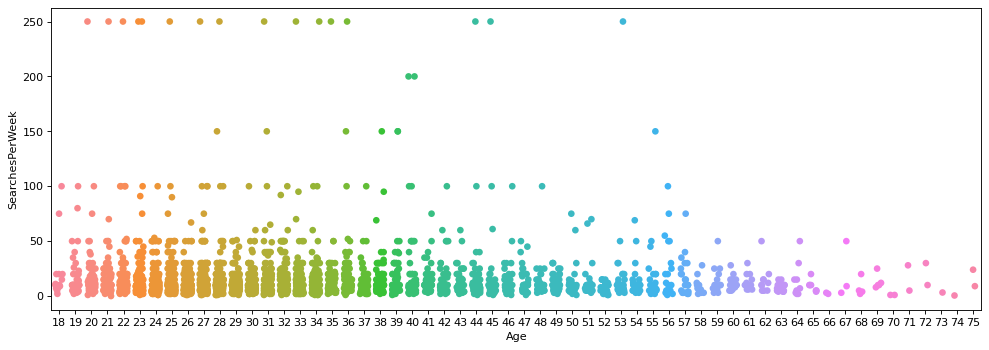

In [56]:
g1 = sc[sc['GroupNumber'] == 1]
g2 = sc[sc['GroupNumber'] == 2]
g3 = sc[sc['GroupNumber'] == 3]
 
g1Age = g1["Age"]
g2Age = g2["Age"]
g3Age = g3["Age"]
groupAges = sc['Age']
searchpw1 = g1["SearchesPerWeek"]
searchpw2 = g2["SearchesPerWeek"]
searchpw3 = g3["SearchesPerWeek"]
groupSpw = sc['SearchesPerWeek']
 
fig,ax = plt.subplots(figsize=(15,5), dpi=80)
sn.stripplot(groupAges,groupSpw,jitter=0.25,size=6,ax=ax)
plt.show()

Here we can see the distribution of Searches Per Week grouped by Age. It is a bit difficult to see which Age group 'Googles' the most. But as we can see the least number of times are with people over 60. 

But what about the distribution in Age Groups?


In [57]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

ssc = remove_outlier(sc,"SearchesPerWeek")

print("AgeGroup 1-6 Mean")
print(sc['SearchesPerWeek'].loc[sc["AgeGroup"] == "Group 1"].mean())

print(sc['SearchesPerWeek'].loc[sc["AgeGroup"] == "Group 2"].mean())

print(sc['SearchesPerWeek'].loc[sc["AgeGroup"] == "Group 3"].mean())

print(sc['SearchesPerWeek'].loc[sc["AgeGroup"] == "Group 4"].mean())

print(sc['SearchesPerWeek'].loc[sc["AgeGroup"] == "Group 5"].mean())

print(sc['SearchesPerWeek'].loc[sc["AgeGroup"] == "Group 6"].mean())

print("AgeGroup 1-6 std")
print(sc['SearchesPerWeek'].loc[sc["AgeGroup"] == "Group 1"].std())

print(sc['SearchesPerWeek'].loc[sc["AgeGroup"] == "Group 2"].std())

print(sc['SearchesPerWeek'].loc[sc["AgeGroup"] == "Group 3"].std())

print(sc['SearchesPerWeek'].loc[sc["AgeGroup"] == "Group 4"].std())

print(sc['SearchesPerWeek'].loc[sc["AgeGroup"] == "Group 5"].std())

print(sc['SearchesPerWeek'].loc[sc["AgeGroup"] == "Group 6"].std())


AgeGroup 1-6 Mean
15.074122236671002
16.047938638542664
17.03970223325062
15.175213675213675
11.482758620689655
11.3
AgeGroup 1-6 std
22.49466863844755
23.25064965282427
26.448267573180626
23.501604021535368
9.55992369942004
11.585910984179593


The average mean for Searches seems to be highest for people in their 30's!

Group 1-6


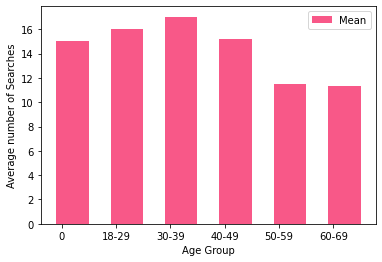

In [58]:
print("Group 1-6")

meanList = []
meanList.append(sc['SearchesPerWeek'].loc[sc["AgeGroup"] == "Group 1"].mean())
meanList.append(sc['SearchesPerWeek'].loc[sc["AgeGroup"] == "Group 2"].mean())
meanList.append(sc['SearchesPerWeek'].loc[sc["AgeGroup"] == "Group 3"].mean())
meanList.append(sc['SearchesPerWeek'].loc[sc["AgeGroup"] == "Group 4"].mean())
meanList.append(sc['SearchesPerWeek'].loc[sc["AgeGroup"] == "Group 5"].mean())
meanList.append(sc['SearchesPerWeek'].loc[sc["AgeGroup"] == "Group 6"].mean())
mean_list_with_outliers = []
mean_list_with_outliers.append(ssc['SearchesPerWeek'].loc[ssc["AgeGroup"] == "Group 1"].mean())
mean_list_with_outliers.append(ssc['SearchesPerWeek'].loc[ssc["AgeGroup"] == "Group 2"].mean())
mean_list_with_outliers.append(ssc['SearchesPerWeek'].loc[ssc["AgeGroup"] == "Group 3"].mean())
mean_list_with_outliers.append(ssc['SearchesPerWeek'].loc[ssc["AgeGroup"] == "Group 4"].mean())
mean_list_with_outliers.append(ssc['SearchesPerWeek'].loc[ssc["AgeGroup"] == "Group 5"].mean())
mean_list_with_outliers.append(ssc['SearchesPerWeek'].loc[ssc["AgeGroup"] == "Group 6"].mean())

mycolors = ["HotPink","Yellow"]
mycolors2 = ["#F85888","#A890F0"]

N = 6
ind = np.arange(N)
width = 0.2

fig = plt.figure()
ax = fig.add_subplot(111)

yvals = mean_list_with_outliers
# rects1 = ax.bar(ind,yvals,width,color=(0.2, 0.4, 0.6, 0.6),label="Mean with outliers")

zvals = meanList
rects2 = ax.bar(ind+width, zvals, width=0.6,color=mycolors2[0],label="Mean")

ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(["0","18-29","30-39","40-49","50-59","60-69","70+"])
ax.legend(loc="upper right")
ax.set_xlabel('Age Group')
ax.set_ylabel('Average number of Searches')
plt.show()

Much better to visualize! This bar plot shows the average number of searches grouped by the age groups. 

Perhaps people in their 30's are more vulnarable than others, due to how often they use search engines. 

How ever, we have confirmed that the average individual "googles" alot. If the Search Engine that people use everyday is a biased one, you can begin to imagine the incluence it could have on peoples mindset, especially on people who are unaware of the bias for the ranking of their Search results.

Many research have shown that Internet search rankings have a significant impact on consumer choice, mainly because users trust and choose higher-ranked results more than lower-ranked results. 
But is there really that much of a difference between the first result (first webpage) and the second??

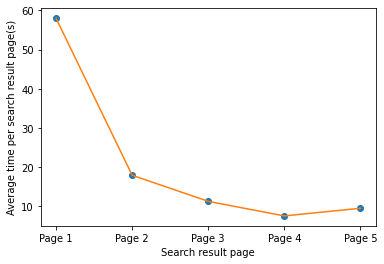

In [59]:
t1 = sc["TimePage1"].mean()
t2 = sc["TimePage2"].mean()
t3 = sc["TimePage3"].mean()
t4 = sc["TimePage4"].mean()
t5 = sc["TimePage5"].mean()
time_list = [t1,t2,t3,t4,t5]
# print(time_list)
plt.ylabel("Average time per search result page(s)")
plt.xlabel("Search result page")
plt.xticks([0,1,2,3,4],["Page 1","Page 2","Page 3","Page 4","Page 5"])
plt.plot(time_list,'o')
plt.plot(time_list)
plt.show()

Yes, and significally so. The average time spent on the first page compared to the second is more than double, almost triple. 

This graph shows the amount of time that subjects spent on each of the five search pages in the user test. As you can see subjects spent most of their time on the first page, which is a common result in Internet search engine research.

But why do people to trust search engine companies to assign higher ranks to the results best suited to their needs, even though users generally have no idea how results get ranked? 

We think that part of the answer lies in the basic design of Search engine result page: the list. An item's position a list has a powerful and persuasive impact on subjects' recollection and evaluation of that item. 

And now lets look at how the user tests were performed!

Like said earlier, our dataset contains data for 3 different studies divided into 3 different groups. We decided to focus on Study 1 and Group 1 for the most part. For Study 1 - 3 the Groups were tested as follows:

The Test for users in **Group 1** was done with a search ranking bias in favour of **David Cameron**, against Ed Milliband.

The Test for Users in **Group 2** was done with a search ranking bias in favour of **Ed Milliband**, against Ed Milliband.

The Test for Users in **Group 3** was a **Neutral** group with alternating search rankings.


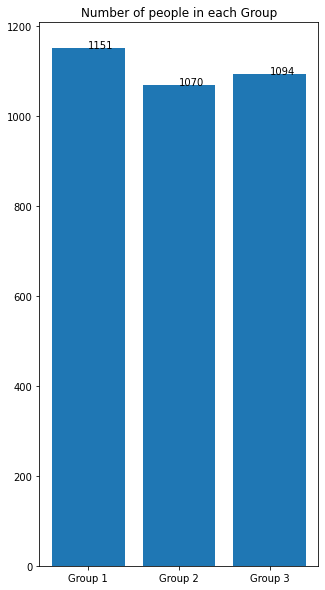

In [60]:
g1 = sc[sc['GroupNumber'] == 1]
g2 = sc[sc['GroupNumber'] == 2]
g3 = sc[sc['GroupNumber'] == 3]

def addtext(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

len_list = [len(g1),len(g2),len(g3)]
names = ["Group 1","Group 2","Group 3"]

plt.figure(figsize=(5,10))
plt.bar(names,len_list)
addtext(names,len_list)
plt.title('Number of people in each Group')
plt.show()

**For the following examples we decided to represent data from Group 1.** That decision was made based on the fact that it has the highest number of participants and we thought it was best to present data from tests with a biased Search engine, rather than neutral.  

Before the user test, subjects were given questions about each candidate and asked to rate their answers on the scale 0-10 of several topics. Which would 
then indicate their voting preference for this election. 
All of the users were eligible voters living in the United States, how ever the election chosen for this experiment was in fact an election for the Prime Minister of the United Kingdom. Each of the three experiments used 30 actual search results and corresponding Web pages relating to the election. Candidates for the election were David Cameron and Ed Miliband, and the order in which their names were presented was counterbalanced in all conditions.  This was done so voters' pre-impression of the candidates would be as unbiased as possible and realistic at the same time. 

Then users were given X time to browse "who to vote" using a Search Engine made by the team, which is a very detailed replica of the Google search engine. What the users didn't know was that the search result ranking could be biased, and part of the experiment was to check if users could detect the bias manipulation. 

After the test users were asked to rate their answers again on each topic regarding each candidate.  

*Now enough with the reading and on to more visualizations!*

Lets see how many undecided voters were likely to vote for each candidate: before the test using the Search Engine compared to the results after the test. 



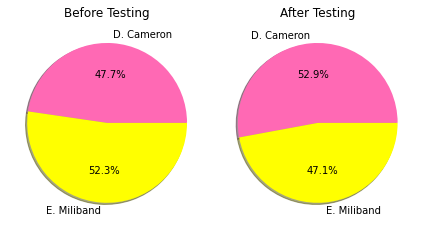

In [61]:
# Lets look at data from Experiementing with Group 1.
# Before the test we want to see how many of undecided voters (percentage) were likely to vote for each candidate. 
pre_likely_bi = [(i >= 0) for i in g1['PreTestLikelyVoteBipolar']]
milliband_pref = pre_likely_bi.count(False)/len(pre_likely_bi) 
cameron_pref = pre_likely_bi.count(True)/len(pre_likely_bi) 

plt.subplot(1,2,1) 
data = np.array([milliband_pref,cameron_pref])
mylabels = ["D. Cameron", "E. Miliband"]

plt.pie(data, labels=mylabels, shadow=True, autopct='%1.1f%%',colors=mycolors)
# plt.legend(title='Preferance', loc='center')
plt.title('Before Testing')
# plt.show()  

post_likely_bi = [(i >= 0) for i in g1['PostTestLikelyVoteBipolar']]
milliband_preff = post_likely_bi.count(True)/len(post_likely_bi) 
cameron_preff = post_likely_bi.count(False)/len(post_likely_bi) 
plt.subplot(1,2,2)
data11 = np.array([milliband_preff,cameron_preff])
plt.pie(data11, labels=mylabels, shadow=True, autopct='%1.1f%%', colors=mycolors)
# plt.legend(title='Preferance', loc='center')
plt.title('After Testing')
plt.tight_layout()
plt.show()


As we can see from the pie charts, the voting preferences lean more towards David Cameron after testing than they did before. And since the user test for this group was biased in favor of David Cameron, it verifies our assumption, that the Search Engine results ranking can in fact alter peoples' mindsets and beliefs towards political candidates. 


It is important to comprehend the use of the `Pre` and `Post` variables in the dataset. 
These columns represent users rating on the scale 0-10, on each candidate for some given observation. Pre columns are representative of user mindset before the test and the Post columns represent their mindset after the testing. 

Let's take a look at some of these essential variables: 

*   Pre- and Post **Impression** of Candidate 1 (David Cameron)  
*   Pre- and Post **Likable** towards Candidate 1 (David Cameron)
*   Pre- and Post **Trust** for Candidate 1 (David Cameron)

In this example we will take two random users as an example of how the rating of these variables distribute. 



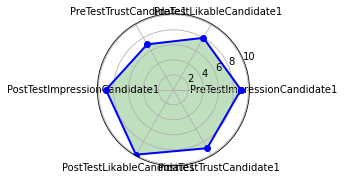

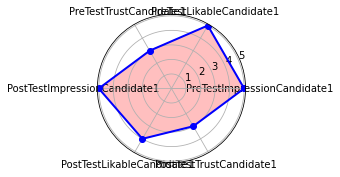

In [62]:
labels = np.array(['PreTestImpressionCandidate1','PreTestLikableCandidate1','PreTestTrustCandidate1',
                'PostTestImpressionCandidate1','PostTestLikableCandidate1','PostTestTrustCandidate1',])
points = g1.loc[123,labels].values

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
points = np.concatenate((points,[points[0]]))
angles = np.concatenate((angles,[angles[0]]))
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(121,polar=True)
ax.plot(angles,points, 'o-', linewidth=2,color="b")
plt.yticks(size=10)
plt.ylim(0)

ax.fill(angles,points, alpha=0.25,color="g")
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.grid(True)

labels = np.array(['PreTestImpressionCandidate1','PreTestLikableCandidate1','PreTestTrustCandidate1',
                'PostTestImpressionCandidate1','PostTestLikableCandidate1','PostTestTrustCandidate1',])


points = g1.loc[2,labels].values

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
points = np.concatenate((points,[points[0]]))
angles = np.concatenate((angles,[angles[0]]))
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(212,polar=True)
ax.plot(angles,points, 'o-', linewidth=2,color="b")
plt.yticks(size=10)
plt.ylim(0)

ax.fill(angles,points, alpha=0.25,color="r")
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.grid(True)

# plt.tight_layout()
plt.show()

Here we see the difference of users rating on the pre and post testing variables. We see that Impressions stay the same which makes sense. 

But what is interesting to see is that for both subjects, rating for Likable and Trust went up 1 point after the testing. So after reading biased information through a biased ranking of search results, these two individuals gained more trust for David Cameron and liked him more. One might conclude that such influence from a Search engine could be used to captivate undecided voters. 

**Next up!**

For the following examples we will take a look at groups 1 and 2. 

Now lets take a look at if users could in fact detect the bias for the search results. For this we will use the 'Bothered' and 'BotheredText' columns. 
For every 'Yes' response to the question if they were bothered by anything during the test, users were asked to give a written response for what bothered them. 



In [63]:
#"Bothered","BotheredText"
bothered_pd = sc[['Bothered','BotheredText']]
bothered_yes = bothered_pd[bothered_pd['Bothered'] == 'Yes']
bothered_no = bothered_pd[bothered_pd['Bothered'] == 'No']
bothered_yes.head(9)

,Bothered,BotheredText
2,Yes,Favored David
3,Yes,I would prefer unbiased search results.
6,Yes,A lot of the articles seemed to be slanted tow...
7,Yes,I wouldn\'t say it bothered me... But the sear...
11,Yes,They were all pro-Cameron
17,Yes,The media\'s views towards the candidates seem...
21,Yes,There wasn\'t one unbiased website
36,Yes,The search results were ordered based on the a...
37,Yes,They largely favored Cameron


But how many people were aware and how many were totally oblivious to the fact that the Search Engine had a bias?



Out of total 3315 people
1901 were not bias aware


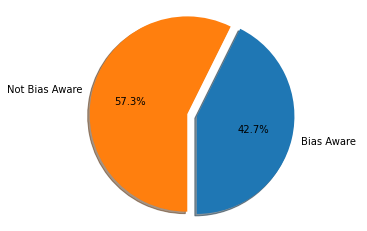

In [64]:
## folk aware vs ekki aware  
options = ['biased', 'bias', 'leaning towards', 'leaning toward', 'leaning against', 'slanted', 'slanted toward', 'skewed', 'skewed toward', 'results favor', 'results favored', 'one sided','favorable toward', 'favorable towards', 
           'favorable for' , 'favorable against' , 'favorable results' , 'favored towards' , 'favored toward' ,'favored for','favored against' , 'favored results' ,'favour toward' , 'favourable towards' , 'favourable toward' ,
           'favourable for' , 'favourable against' , 'favourable results' ,'favoured towards' , 'favoured toward' , 'favoured for' ,'favoured against' , 'favoured results' ,'favour toward' ,'results favour' , 'results favoured' ,
           'favor Cameron', 'favor Miliband' , 'favour Cameron' , 'favour Miliband' , 'pro Cameron' , 'pro Miliband' ,'pro-Cameron' , 'pro-Miliband' ,'Cameron leaning'  , 'Miliband leaning' , 'negative toward', 'negative for' , 
           'negative against', 'postive toward', 'postive for' ,'postive against' , 'all postive', 'all negative' ,'mainly positive', 'mainly negative' , 'mostly positive' , 'mostly negative' , 'more negativity' ,
           'nothing positive' , 'nothing negative' ,'more results for' , 'less results for' , 'most of the articles were negative' , 'most of the articles were positive']


# selecting rows based on condition
bias_count = 0
for i in options:
  bias_count+=bothered_pd['BotheredText'].str.contains(i).sum()



print("Out of total {m} people".format(m=bothered_pd.shape[0]))
print("{m} were not bias aware".format(m=(bothered_pd.shape[0]-bias_count)))
cake = np.array([bias_count, bothered_no.shape[0]])
explode = (0.1,0)
labels = ["Bias Aware", "Not Bias Aware"]

fig1, ax1 = plt.subplots()
ax1.pie(cake, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=270)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


# df_corr = b_no[['PreTestImpressionCandidate1','PreTestLikableCandidate1','PreTestTrustCandidate1',
#                 'PostTestImpressionCandidate1','PostTestLikableCandidate1','PostTestTrustCandidate1',]]


After evaluation, it seems to be that the manipulation through this search engine was subtle enough to fool 57.3% of the people who used it. 

That means that out of 3315 people, 1901 did not realize they were getting biased search results.

Quite impressive and quite concerning. 

So let's say if someone was leaning more towards voting for Ed Miliband, could this type of manipulation influence that someone  to change his/hers mind and vote for David Cameron?

Let's take a look at how many people changed their mind and voted for the bias favored candidate, after taking the test.
In other words: **How many voters changed their vote because of SEME?**

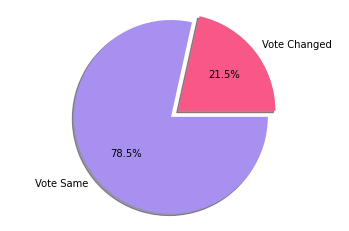

In [65]:
# g1_pd = g1[['Bothered','BotheredText']]
# g1_yes = g1_pd[g1_pd['Bothered'] == 'Yes']
# g1_no = g1[g1_pd['Bothered'] == 'No']

count = sc.loc[sc['VoteChanged'] == 1].count()
count2 = sc.loc[sc['VoteChanged'] == 0].count()
vote_change = sc.loc[sc['VoteChanged'] == 1]
count3 = vote_change.loc[vote_change['Bothered'] == 'No'].count()
count4 = vote_change.loc[vote_change['Bothered'] == 'Yes'].count()


cake = np.array([count['Age'],count2['Age']])
explode = (0.1,0)
labels = ["Vote Changed", "Vote Same"]

fig1, ax1 = plt.subplots()
ax1.pie(cake, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=360, colors=mycolors2)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


**21.5 % of people from this study changed their minds on who to vote because their beliefs were changed with the use of a biased search engine.**




# Conclusion of Data Analysis

This analysis demonstrates the influence biased Search result rankings have on peoples mindset and beliefs toward election candidates.
It is fairly obvious that such search engines could affect, and perhaps already are affecting, the outcomes of close elections worldwide.
Firstly, the analysis confirmed that more then half of people using those Search engines are unaware they are being manipulated, and tend to think instead that they have voluntarily adopted this new way of thinking. Such manipulations are obviously difficult to detect and most people are quite powerless trying to resist some flow of influence not visible to them. 

Shifts in voting preferences lead to change of beliefs, a change of voting for 20% of voters, which is a frightening number since most of elections today are won by a small margin, easily compattible with that percentage. 

The results suggest that a search engine company has the power to influence the results of elections. The impact of such manipulations would be especially large in countries dominated by a single search engine company, like Google for example. 

All in all: These results could be viewed as a great cause for concern. 

# Machine Learning model - Training our models to predict the likelyhood of Vote Change

We decided to make 3 models. Our goal will be to predict which of the two outcomes (vote change or not) is more likely to happen based on our variables (Supervised learning!). 

**Data properties:**
*   Tabular
*   Multivariate Dataset
*   Data used for modelling consists of numerical variables
*   Classification problem
*   Minority class is ~ 22%

Because of these properties we chose Random Forest Classifier and XGBoost. 

To test models accuracy we used the following methods:

*   R-Squared test
*   Cross-Validation
*   Recall test
*   Precision test
*   Confusion Matrix



In [66]:
machine = sc 
machine = machine.dropna(axis=0, how='any')

X = machine[['PreTestImpressionCandidate1','PreTestLikableCandidate1','PreTestTrustCandidate1','PreTestLikelyVoteBipolar',
                'PostTestImpressionCandidate1','PostTestLikableCandidate1','PostTestTrustCandidate1','PostTestLikelyVoteBipolar']].values
y = machine['VoteChanged']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


For the X data variable we set all of the `Pre` and `Post` features of the dataset. And the target variable Y would be `VoteChanged`. The data was split into 80% training set and 20% test set. 

### Random Forest Classification Model

In [67]:
# RandomForestClassifier model
rf = RandomForestClassifier(random_state=30)
clf = rf.fit(X_train, y_train)
data_predictions = rf.predict(X_test)
accuracy = accuracy_score(y_test, data_predictions)
print('Accuracy= '+ str(accuracy))

cf_matrix = confusion_matrix(y_test, data_predictions)
r2_rf = r2_score(y_test,data_predictions)
print("R-Squared test: ", r2_rf)

# print("Cross validation Score: ", cross)
recall = recall_score(y_test,clf.predict(X_test))
precision = precision_score(y_test,clf.predict(X_test),zero_division=0)
print('Recall: ',recall)
print('Precision: ',precision)

Accuracy= 0.9376899696048632
R-Squared test:  0.6136340852130326
Recall:  0.7368421052631579
Precision:  0.9423076923076923


Our model seem to have perfomed well. We would like to see the R-Squared test a bit higher but the precision is excellent and recall also good. We made a confusion matrix of the Random Forest Classifier to better visualize.

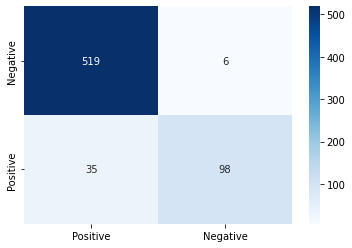

In [68]:
yaxis = ["Negative","Positive"]
xaxis = ["Positive","Negative"]

sn.heatmap(cf_matrix,annot=True,fmt='d',cmap="Blues",xticklabels=xaxis,yticklabels=yaxis)

### XG Boost Classifier

Accuracy:  0.9513677811550152
R-Squared test:  0.6984461152882206


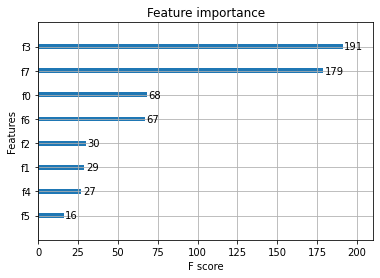

In [69]:
xg = xgb.XGBClassifier(random_state=30)

xg.fit(X_train, y_train)
xg_pred = xg.predict(X_test)
r2_xg = r2_score(y_test,xg_pred)
accuracy_xg = accuracy_score(y_test, xg_pred)
print('Accuracy: ', accuracy_xg)
print("R-Squared test: ", r2_xg)
xgb.plot_importance(xg)
plt.show()

Here we can see importance of the features. The two features f3 `PreTestLikelyVoteBipolar` and f7 `PostTestLikelyVoteBipolar` are by no surprise the ones that offer the most predictive value. 

Negative numbers on the bipolar candidate preference scale `PreTestLikelyVoteBipolar` and `PostTestLikelyVoteBipolar` indicate a preference for Ed Milliband and positive numbers indicate a preference for David Cameron. 

The correlation between the two is understandibly a big factor in predicting if vote behavior changes or not. 

We then performed a 5-fold cross validation on the training data using GridSearchCV to find the best parameter values. 
We tuned the max_depth (values 2-8) and subsample (values 0.5, 0.6, 0.7, 0.8, 0.9, 1)

In [70]:
xgboost2 = xgb.XGBClassifier(random_state=30)
param_gridB = [{'max_depth': [2,3,4,5,6,7,8], 'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]}]

grid_search2 = GridSearchCV(xgboost2, param_gridB, cv=5)
search_results = grid_search2.fit(X_train, y_train)

final_model = grid_search2.best_estimator_

final_predictions = final_model.predict(X_test)

final_accuracy = accuracy_score(y_test, final_predictions)
r2_xg2 = r2_score(y_test,final_predictions)
print('Final accuracy: ', final_accuracy)
print("R-Squared test: ", r2_xg2)
print('Best parameters for max_depth: ',final_model.max_depth)
print('Best parameters for subsample: ',final_model.subsample)

Final accuracy:  0.9620060790273556
R-Squared test:  0.7644110275689223
Best parameters for max_depth:  4
Best parameters for subsample:  0.6


Having a multivariate dataset we had to do some more exploring.

Just for the fun of it we wanted to experiment with training a model which is good at text classification, since we have can use "BotheredText" text box from users. We decided to train a Support Vector Machine. We wanted to see if we could create a classifier that given the answer from a text box, predicts if the user changed their vote. 



In [71]:
line = sc[sc['Bothered'] == 'Yes']
lines = line['BotheredText']
lines = lines.dropna(axis=0, how='any')
target = line['VoteChanged']
# print(target)
vectorizer = TfidfVectorizer(max_features=2)
XX = vectorizer.fit_transform(lines)

XX_train, XX_test, YY_train, YY_test = train_test_split(XX, target, test_size= .2, random_state= 30)

Svm = SVC(kernel='linear')

Svm.fit(XX_train, YY_train)

accuracy3 = Svm.score(XX_test, YY_test)
print('Accuracy for SVM: ', accuracy3)


Accuracy for SVM:  0.8056537102473498


# Model Conclusion

In conclusion we beleive our models performed well. There was not great difference between the accuracy of the models: 


*   Random Forest = 93.7%
*   XGBoost = 95.1%
*   XGBoost Final = 96.2%
*   Support Vector Machine = 80.5%

But according to the R-Squared test the best model performance was with the parameter tuned XGBoost model. 
The reason for the similarity between accuracy of the Random Forest and XGB models were due to the fact that the data is numeric and every value is on the scale 0-10. Prediction should be pretty straight forward working with such data, without noice or any bias variance, which made the use for highly advanced models on the subject unnecessary.  
The SVM accuracy was also good but the least one, since working with text data is always a bit tricky.